# Project Fletcher - Weeks 07 and 08

# _Natural Language Processing of Economic News Articles_, by Steven Bierer

## Data Assessment
(Jupyter Notebook 1 of 2)

#### ------ Section 1:  Load the data as a dataframe and clean up the text -----------

In [1]:
import numpy as np
import pandas as pd
import re

pd.set_option('max_colwidth',80)

In [3]:
# Load in the data set and keep only the important information #
df = pd.read_csv('data/NewsEcon2.csv',encoding ='latin1')
df = df[['articleid','headline','text','relevance','positivity']]

In [4]:
# Look at the first couple of articles #
# Note that positivity is NaN when relevance = 'no'.
df.head(2)

,articleid,headline,text,relevance,positivity
0,wsj_398217788,Yields on CDs Fell in the Latest Week,NEW YORK -- Yields on most certificates of deposit offered by major banks dr...,yes,3.0
1,wsj_399019502,The Morning Brief: White House Seeks to Limit Child Insurance Program,"The Wall Street Journal Online</br></br>The Morning Brief, a look at the day...",no,NaN


In [16]:
# Define some of the known titles and headers to remove from the text #
REMOVE_PREFIX = re.compile( "^([A-Z ]+ -- |"
                            "The Wall Street Journal Online</br></br>The Morning Brief,[^<]*</br></br>|"
                            "Author:[^<]*</br></br>|"
                            "The Wall Street Journal Online|"
                            "The Morning Brief:|"
                            "Manager's Journal|"
                            "\[[\w ]*\]</br></br>|"
                            "\[[\w ]*\])"
                          )
# Also define certain non-text characters and formatting for removal #
REPLACE_TEXT = {"</br></br>":" ", ":":" ", "--":" "}

In [472]:
# Define and clean up the data #
clean_articles = list(df['text'])
clean_headlines = list(df['headline'])
y_relevance = list(df['relevance'])
y_positivity = list(df['positivity'])

clean_articles = [re.sub(REMOVE_PREFIX,'',entry) for entry in clean_articles]
for k,v in REPLACE_TEXT.items():
    clean_articles = [re.sub(k,v,entry.strip()) for entry in clean_articles]
    
clean_headlines = [re.sub(REMOVE_PREFIX,'',entry) for entry in clean_headlines]
for k,v in REPLACE_TEXT.items():
    clean_headlines = [re.sub(k,v,entry.strip()) for entry in clean_headlines]

In [473]:
# Save the claned text data and labels #
import pickle

with open('data/clean_articles.pkl', 'wb') as picklefile:
    pickle.dump(clean_articles, picklefile)
with open('data/clean_headlines.pkl', 'wb') as picklefile:
    pickle.dump(clean_headlines, picklefile)
with open('data/y_relevance.pkl', 'wb') as picklefile:
    pickle.dump(y_relevance, picklefile)
with open('data/y_positivity.pkl', 'wb') as picklefile:
    pickle.dump(y_positivity, picklefile)

#### ------ Section 2:  Parse the text into tokens ----------------------------
Both common English and named entity tokens will be identified, the former as lemmatized strings.

In [27]:
import spacy
from spacy.lang.en import English
import nltk
from nltk.corpus import wordnet
from gensim import corpora

nlp = spacy.load('en_core_web_md')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/neuromac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [351]:
# Import utility functions for tokenizing and token counting #
import NLP_Analysis
import importlib
importlib.reload(NLP_Analysis)  # makes it easy to reload for notebook
from NLP_Analysis import tokenize, make_dictionary, make_tftable

In [284]:
# Define the stop words for the main token parsing #
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.add('%')        # many of these pass through, so filter early

In [287]:
# Create a corpus of headlines consisting of desired tokens #
# This uses a custom utility function to creat the dictionary #
TAGS = ['NOUN','VERB','ADJ','ADV','ORG']

dict_headlines, alltokens = \   # utility function in NLP_Analysis.py to tokenize
    make_dictionary(clean_headlines, nlp, en_stop, TAGS)

dictsize1 = len(dict_headlines) # limit the acceptable tokens
dict_headlines.filter_extremes(no_below=3, no_above=0.8, keep_n=10000)
dictsize2 = len(dict_headlines)
print(f'Dictionary pared from {dictsize1} to {dictsize2} entries.')
                                # create a list of tokens for each document
corpus_headlines = [dict_headlines.doc2bow(tokens) for tokens in alltokens]
print(f'Corpus of {len(corpus_headlines)} documents created.')

500, 
1000, 
1500, 
2000, 
2500, 
3000, 
3500, 
4000, 
4500, 
5000, 
5500, 
6000, 
6500, 
7000, 
7500, 
8000, 

Dictionary pared from 12652 to 3254 entries.
Corpus of 8000 documents created.


In [291]:
# Repeat for the newspaper articles #
# Ultimately, the article text is of more interest than the headlines.
TAGS = ['NOUN','VERB','ADJ','ADV','ORG','GPE']

dict_articles, alltokens = \
    make_dictionary(clean_articles, nlp, en_stop, TAGS)

dictsize1 = len(dict_articles)
dict_articles.filter_extremes(no_below=3, no_above=0.8, keep_n=30000)
dictsize2 = len(dict_articles)
print(f'Dictionary pared from {dictsize1} to {dictsize2} entries.')

corpus_articles = [dict_articles.doc2bow(tokens) for tokens in alltokens]
print(f'Corpus of {len(corpus_articles)} documents created.')

500, 
1000, 
1500, 
2000, 
2500, 
3000, 
3500, 
4000, 
4500, 
5000, 
5500, 
6000, 
6500, 
7000, 
7500, 
8000, 

Dictionary pared from 54827 to 17903 entries.
Corpus of 8000 documents created.


In [48]:
# Look at a random selection (+1 entity) of the dictionary entries #
for i in np.random.randint(0,8000,5):
    print(i, dict_articles[i])
print(dict_articles.token2id.get('MEDICARE'), 'MEDICARE')

6499 wore
6692 motorola
2779 kid
3839 certainly
1575 sectors
3713 MEDICARE


In [9]:
# As an example, look at the word tallies for one of the headlines #
print(clean_headlines[4])
print([(k,dict_headlines[k],v) for k,v in corpus_headlines[4]])

Currency Trading  Dollar Remains in Tight Ranges Amid Wait for U.S. Jobs Data
[(26, 'currency', 1), (27, 'data', 1), (28, 'dollar', 1), (29, 'jobs', 1), (30, 'ranges', 1), (31, 'remains', 1), (32, 'tight', 1), (33, 'trading', 1), (34, 'wait', 1)]


In [106]:
# Save the data #
import pickle

with open('data/corpus_headlines.pkl', 'wb') as picklefile:
    pickle.dump(corpus_headlines, picklefile)
with open('data/corpus_articles.pkl', 'wb') as picklefile:
    pickle.dump(corpus_articles, picklefile)
with open('data/dict_headlines.pkl', 'wb') as picklefile:
    pickle.dump(dict_headlines, picklefile)
with open('data/dict_articles.pkl', 'wb') as picklefile:
    pickle.dump(dict_articles, picklefile)

#### ---- Section 3:  Visualize token frequencies ---------------
Specifically interested in comparing tokens in "relevant" versus
"nonrelevant" artiles (as judged by the surveyed readers).

In [419]:
# Make term-frequency tables, to facilitate visualizing token counts #
# "_hr" refers to relevant headlines, "_hn" to nonrelevant, etc.
from itertools import compress   # efficient way to boolean mask a list

mask_rel = df['relevance']=='yes'
mask_not = df['relevance']=='no'
corpus_hr = [entry for entry in list(compress(corpus_headlines, mask_rel))]
corpus_hn = [entry for entry in list(compress(corpus_headlines, mask_not))]
corpus_ar = [entry for entry in list(compress(corpus_articles, mask_rel))]
corpus_an = [entry for entry in list(compress(corpus_articles, mask_not))]

tf_hr = make_tftable(dict_headlines, corpus_hr)  # utility function
tf_hn = make_tftable(dict_headlines, corpus_hn)
tf_ar = make_tftable(dict_articles, corpus_ar)
tf_an = make_tftable(dict_articles, corpus_an)

In [434]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

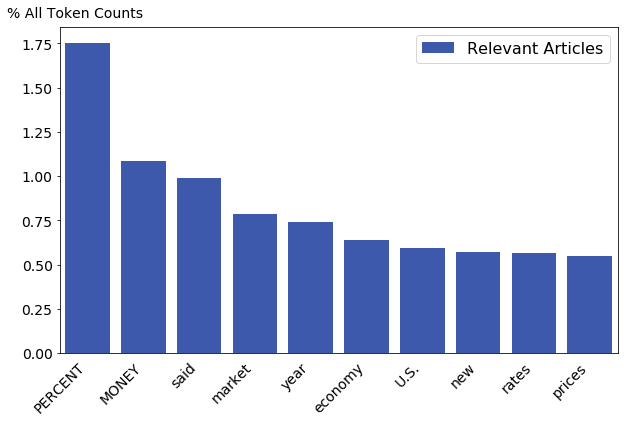

In [468]:
# Make a bar chart of most-frequent relevant article tokens #
N = 10
xx = np.arange(N)
yysum = tf_ar['count'].sum()
yy1 = np.array(tf_ar['count'][:N]) * 100/yysum
tokens = list(tf_ar['token'][:N])

plt.bar(xx, yy1, color='#3D59AB');
plt.xticks(xx, tokens, rotation=45, ha='right');
plt.xlim(xx[0]-.5,xx[-1]+.5);
plt.tick_params(axis='x', bottom=False)
plt.tick_params(axis='both', which='major', labelsize=14)

fig = plt.gcf(); ax = plt.gca(); 
fig.set_figwidth(10); fig.set_figheight(6)
ax.set_ylabel('% All Token Counts', fontsize=14, rotation = 0, ha='right')
ax.yaxis.set_label_coords(0.15, 1.02)
plt.legend(['Relevant Articles'], fontsize=16);

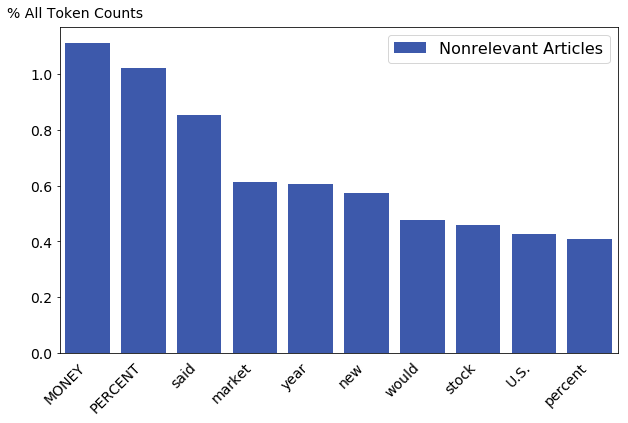

In [467]:
# Top tokens from nonrelevant articles are similar! #
# Even the named entity "U.S" appears, presumably in articles about the U.S.
# that aren't necessarily about the economy. This will make the yes/no
# relevance classification prediciton difficult.
N = 10
xx = np.arange(N)
yysum = tf_an['count'].sum()
yy1 = np.array(tf_an['count'][:N]) * 100/yysum
tokens = list(tf_an['token'][:N])

plt.bar(xx, yy1, color='#3D59AB');
plt.xticks(xx, tokens, rotation=45, ha='right');
plt.xlim(xx[0]-.5,xx[-1]+.5);
plt.tick_params(axis='x', bottom=False)
plt.tick_params(axis='both', which='major', labelsize=14)

fig = plt.gcf(); ax = plt.gca(); 
fig.set_figwidth(10); fig.set_figheight(6)
ax.set_ylabel('% All Token Counts', fontsize=14, rotation = 0, ha='right')
ax.yaxis.set_label_coords(0.15, 1.02)
plt.legend(['Nonrelevant Articles'], fontsize=16);